# Tutorial on Gaussian Mixture Models and clustering

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import mixture
from sklearn import cluster

## Gaussian Mixture Models (GMM)

The [`sklearn.mixture`](https://scikit-learn.org/stable/modules/mixture.html) module provides facilities to learn GMMs (diagonal, spherical, tied and full covariance matrices supported), sample them, and estimate them from data.

### What is a GMM?

A probabilistic model for the data generation process
$$
z_{i} \sim Categorical\left(\vec{p}\right)\\
x_{i} \sim N\left(\vec{\mu_{z_{i}}},\Sigma_{z_{i}}\right)
$$

$z_{i}$ is the observation $x_{i}$'s class label, which is chosen with some probability. The class label determines the mean and covariance matrix of the multivariate normal distribution that is used to generate the sample $x_{i}$. There are four kinds of covariances that can be used with `sklearn`'s GMMs:
1. `spherical`, all clusters can have different covariances. All features for a given cluster share the same variance.
2. `diagonal`, all clusters can have different covariances. All features for a given cluster are uncorrelated from each other, but can have different variances. 
3. `tied`, all clusters share the same covariance matrix. The covariance matrix can have arbitrary correlations between features.
4. `full`, all clusters have an independent covariance matrix. Each covariance matrix can have arbitrary correlations between features.

A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. One can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians.

The cluster parameters $\vec{\mu_{z_{i}}}$ and $\Sigma_{z_{i}}$ are fitted by maximizing the likelihood of the observed data through the [EM algorithm](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm).

The main difficulty in learning Gaussian mixture models from unlabeled data is that it is one usually doesn’t know which points came from which latent component (if one has access to this information it gets very easy to fit a separate Gaussian distribution to each set of points). Expectation-maximization is a well-founded statistical algorithm to get around this problem by an iterative process. First one assumes random components (randomly centered on data points, learned from k-means, or even just normally distributed around the origin) and computes for each point a probability of being generated by each component of the model. Then, one tweaks the parameters to maximize the likelihood of the data given those assignments. Repeating this process is guaranteed to always converge to a local optimum.

### Advantages
* Extremely fast optimization

### Drawbacks
* The model is not bayesian as there are no priors over the cluster probabilities $\vec{p}$ (in principle, $\vec{p}$ is assumed to be uniform by sklearn) nor over the multivariate normal parameters: $\vec{\mu_{z_{i}}}$ and $\Sigma_{z_{i}}$.
* With this The number of clusters should be known a priori
* The lack of priors over parameters can lead to numerical instabilities when there are few datapoints.

In [2]:
# Fake data generator
from numpy import random as nr
from scipy.stats import random_correlation

def data_generator(n_components=2,
                   n_features=2,
                   component_prob=None,
                   mean=None,
                   covariance=None,
                   size=None,
                   return_labels=False,
                   return_parameters=False,
                  ):
    if mean is None:
        mean = nr.normal(0, 1, size=(n_components, n_features))
    if covariance is None:
        sigmas = nr.gamma(shape=1., scale=1., size=(n_components, n_features))
        eigs = nr.rand(n_features)
        eigs = eigs / np.sum(eigs) * n_features
        covariance = np.array(
            [np.dot(random_correlation.rvs(eigs), np.diag(sigma))
             for sigma in sigmas]
        )
    if component_prob is None:
        component_prob = np.ones(n_components) / n_components
    clusters = np.arange(n_components)
    if size is None:
        z = nr.choice(clusters, p=component_prob)
        obs = nr.multivariate_normal(mean=mean[z],
                                     covariance=covariance[z])
        labels = np.array(z).astype(np.int)
    else:
        if isinstance(size, int):
            size = (size,)
        else:
            size = tuple(size)
        size_ = np.prod(size)
        obs = []
        labels = []
        for i in range(size_):
            z = nr.choice(clusters, p=component_prob)
            obs.append(
                nr.multivariate_normal(mean=mean[z],
                                       cov=covariance[z])
            )
            labels.append(z)
        obs = np.reshape(np.array(obs), size + (n_features,))
        labels = np.array(labels).astype(np.int)
    output = (obs,)
    if return_labels:
        output += (labels,)
    if return_parameters:
        output += (mean, covariance)
    if len(output) == 1:
        output = output[0]
    return output

/home/lpaz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: covariance is not positive-semidefinite.


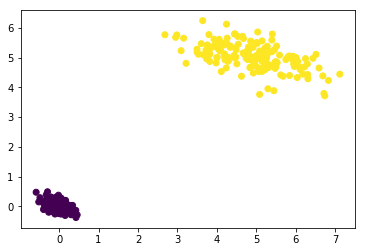

In [3]:
centers = np.array([[0, 0], [5, 5]])
X_train, y_train = data_generator(
    n_components=len(centers),
    mean=centers,
    return_labels=True,
    size=300)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

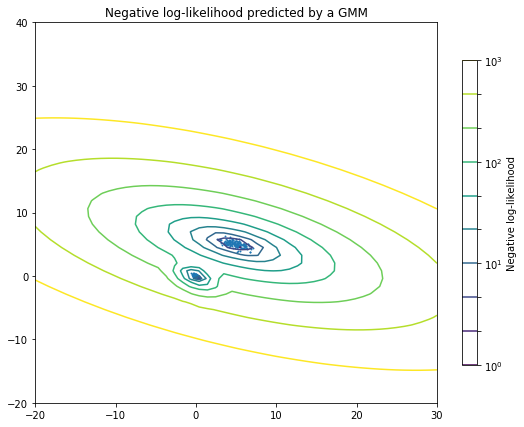

In [4]:
clf = mixture.GaussianMixture(n_components=len(np.unique(y_train)),
                              covariance_type='full')
clf.fit(X_train)

# display predicted scores by the model as a contour plot
x = np.linspace(-20., 30.)
y = np.linspace(-20., 40.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)

plt.figure(figsize=(9, 7))
from matplotlib.colors import LogNorm
CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
CB = plt.colorbar(CS, shrink=0.8, extend='both')
CB.set_label('Negative log-likelihood')
plt.scatter(X_train[:, 0], X_train[:, 1], .8)

plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
plt.show()

[GaussianMixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture) implements a series of methods used in non-supervised learning and in some clustering algorithms:

* aic(X): Akaike information criterion for the current model on the input X.
* bic(X): Bayesian information criterion for the current model on the input X.
* fit(X[, y]): Estimate model parameters with the EM algorithm. The y input is ignored.
* fit_predict(X[, y]): Estimate model parameters using X and predict the labels for X. The y input is ignored.
* predict(X): Predict the labels for the data samples in X using trained model.
* predict_proba(X): Predict posterior probability of each component given the data.
* sample([n_samples]): Generate random samples from the fitted Gaussian distribution.
* score(X[, y]): Compute the per-sample average log-likelihood of the given data X.
* score_samples(X): Compute the weighted log probabilities for each sample.

##### You can attempt to predict the labels with predict

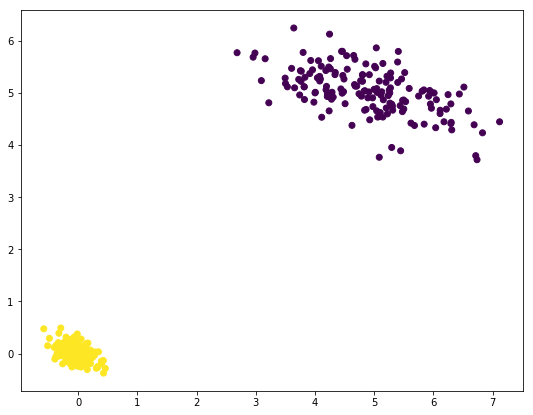

In [5]:
y_pred = clf.predict(X_train)
plt.figure(figsize=(9, 7))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_pred)

Be aware of __label switching__. In this situation, the data is correctly split into the clusters but the predicted labels can have a different identifier number than the true label. In those situations, the accuracy will be artificially low.

In [6]:
from sklearn.metrics import accuracy_score
accuracy_score(y_pred, y_train)

0.0

##### Being a probabilistic model, you can predict the probability of belonging to a label

In [7]:
centers = np.array([[0, 0], [2, 1], [-1, 2]])
X_train, y_train = data_generator(
    n_components=len(centers),
    mean=centers,
    return_labels=True,
    size=300)

/home/lpaz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: covariance is not positive-semidefinite.


(10000, 3)


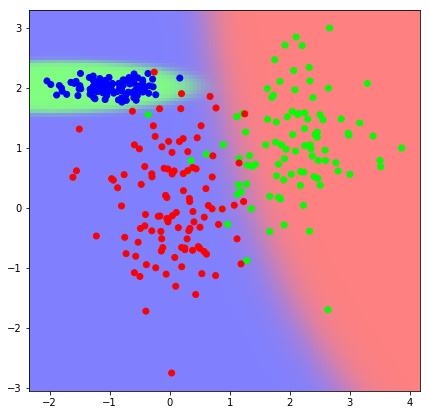

In [8]:
# View raw data
from matplotlib.colors import LinearSegmentedColormap

clf = mixture.GaussianMixture(n_components=len(np.unique(y_train)),
                              covariance_type='full')
y_pred = clf.fit_predict(X_train)

colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1)]  # R -> G -> B
cmap_name = 'my_list'
cmap = LinearSegmentedColormap.from_list(
    cmap_name, colors, N=3
)

# Fit with GMM
clf.fit(X_train)

# Plot label probability

plt.figure(figsize=(12, 7))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train,
            cmap=cmap)
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
X, Y = np.meshgrid(np.linspace(xlim[0], xlim[1], 100),
                   np.linspace(ylim[0], ylim[1], 100)
                   )
Z = clf.predict_proba(np.array([X.flatten(), Y.flatten()]).T)
print(Z.shape)
plt.imshow(np.reshape(Z, (X.shape[0], X.shape[1], 3)),
           extent=xlim + ylim, alpha=0.5, origin='lower')
# Colors may not match due to label switching!!

##### Finally, we can take advantage of the BIC and AIC information criteria to select the number of components

In [9]:
clfs = [mixture.GaussianMixture(n_components=i,
                                covariance_type='full').fit(X_train)
        for i in range(2, 5)]
print([(clf.n_components, clf.bic(X_train)) for clf in clfs])

[(2, 1548.1682859972093), (3, 1536.3644623777595), (4, 1563.3616754307964)]


#### Exercises
1. Load the iris dataset and fit it with a GaussianMixture that has 3 components. Plot the preditions using the 4 different kinds of covariances.
2. Load the iris dataset and fit it with a GaussianMixture with varying numbers of components. Use AIC and BIC to decide the "optimal" number of components.
3. Consider the following dataset:
```python
centers = np.tile((np.arange(4) * 3)[:, None], (1, 2))
X_train, y_train = data_generator(
        n_components=len(centers),
        mean=centers,
        return_labels=True,
        size=600)
```
What is the true number of mixture components, and what is the number that gets the best BIC?

## `BayesianGaussianMixture`

To get a bayesian model, you have to specify priors over the parameters. scikit-learn allows you to partially do this by specifying that the category to which each observation belongs to is generated from a 1) [Dirichlet distribution](https://en.wikipedia.org/wiki/Dirichlet_distribution) or 2) a [Dirichlet Process](https://en.wikipedia.org/wiki/Dirichlet_process). This allows you to infer the number of components from the data (and prior information).

In [10]:
from sklearn.mixture import BayesianGaussianMixture

In [11]:
clf_dp = BayesianGaussianMixture(
    n_components=10,
    weight_concentration_prior_type='dirichlet_process',
    weight_concentration_prior=None, # Not used with DP
)
clf_dd = BayesianGaussianMixture(
    n_components=10,
    weight_concentration_prior_type='dirichlet_distribution',
    weight_concentration_prior=1.,
)
clf_dp.fit(X_train)
clf_dd.fit(X_train)

/home/lpaz/anaconda3/lib/python3.6/site-packages/sklearn/mixture/base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
            degrees_of_freedom_prior=None, init_params='kmeans',
            max_iter=100, mean_precision_prior=None, mean_prior=None,
            n_components=10, n_init=1, random_state=None, reg_covar=1e-06,
            tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
            weight_concentration_prior=1.0,
            weight_concentration_prior_type='dirichlet_distribution')

In [12]:
# We can see the fitted component weights and parameters
print('weights = {}'.format(clf_dp.weights_))
print('means = {}'.format(clf_dp.means_))
print('covariances = {}'.format(clf_dp.covariances_))
# Note that all weights except for 3 are almost zero

weights = [3.47123132e-01 3.56661354e-03 1.14275199e-02 3.52675614e-03
 3.50688262e-03 3.48712861e-03 3.42722085e-01 2.84324042e-01
 2.89520243e-04 2.63199534e-05]
means = [[-9.46075401e-01  1.97985305e+00]
 [ 3.19073621e-01  1.00786314e+00]
 [ 1.02430213e+00 -2.44611944e-04]
 [ 3.19161564e-01  1.00795823e+00]
 [ 3.19205264e-01  1.00800556e+00]
 [ 3.19248553e-01  1.00805248e+00]
 [ 9.45012950e-02  4.93641586e-03]
 [ 2.06129437e+00  1.12897583e+00]
 [ 3.25138340e-01  1.01492639e+00]
 [ 3.25138531e-01  1.01492663e+00]]
covariances = [[[ 0.24542557 -0.02174904]
  [-0.02174904  0.03675202]]

 [[ 0.93846235 -0.15132201]
  [-0.15132201  0.55436593]]

 [[ 1.51387233 -0.97669501]
  [-0.97669501  1.33122384]]

 [[ 0.93838795 -0.15134492]
  [-0.15134492  0.55442949]]

 [[ 0.93835097 -0.15135632]
  [-0.15135632  0.55446111]]

 [[ 0.93831432 -0.15136762]
  [-0.15136762  0.55449245]]

 [[ 0.39980321 -0.02716754]
  [-0.02716754  0.65445557]]

 [[ 0.48956751  0.05664769]
  [ 0.05664769  0.53046624]]


In [13]:
# We can see the fitted component weights and parameters
print('weights = {}'.format(clf_dd.weights_))
print('means = {}'.format(clf_dd.means_))
print('covariances = {}'.format(clf_dd.covariances_))
# Note that all weights except for 3 are almost zero

weights = [0.33676614 0.00728062 0.00347289 0.34509278 0.0034702  0.0034702
 0.0034702  0.0034702  0.29003657 0.0034702 ]
means = [[-0.9469954   1.98010255]
 [ 1.2362672  -0.08095098]
 [ 0.31969019  1.00827982]
 [ 0.09256698  0.0074686 ]
 [ 0.31977898  1.00836058]
 [ 0.31977898  1.00836058]
 [ 0.31977898  1.00836058]
 [ 0.31977898  1.00836058]
 [ 2.05646754  1.12092571]
 [ 0.31977898  1.00836058]]
covariances = [[[ 0.24474685 -0.02163974]
  [-0.02163974  0.03666365]]

 [[ 1.4586294  -1.02753855]
  [-1.02753855  1.46849827]]

 [[ 0.93785086 -0.15165307]
  [-0.15165307  0.55482183]]

 [[ 0.40286541 -0.03193013]
  [-0.03193013  0.65839201]]

 [[ 0.93778917 -0.1516697 ]
  [-0.1516697   0.55486887]]

 [[ 0.93778917 -0.1516697 ]
  [-0.1516697   0.55486887]]

 [[ 0.93778917 -0.1516697 ]
  [-0.1516697   0.55486887]]

 [[ 0.93778917 -0.1516697 ]
  [-0.1516697   0.55486887]]

 [[ 0.49358346  0.05815991]
  [ 0.05815991  0.54199   ]]

 [[ 0.93778917 -0.1516697 ]
  [-0.1516697   0.55486887]]]


In [14]:
from matplotlib import gridspec
import matplotlib as mpl


def plot_ellipses(ax, weights, means, covars):
    for n in range(means.shape[0]):
        eig_vals, eig_vecs = np.linalg.eigh(covars[n])
        unit_eig_vec = eig_vecs[0] / np.linalg.norm(eig_vecs[0])
        angle = np.arctan2(unit_eig_vec[1], unit_eig_vec[0])
        # Ellipse needs degrees
        angle = 180 * angle / np.pi
        # eigenvector normalization
        eig_vals = 2 * np.sqrt(2) * np.sqrt(eig_vals)
        ell = mpl.patches.Ellipse(means[n], eig_vals[0], eig_vals[1],
                                  180 + angle, edgecolor='black')
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(weights[n])
        ell.set_facecolor('#56B4E9')
        ax.add_artist(ell)


def plot_results(ax1, ax2, estimator, X, y, title, plot_title=False, n_components=2):
    ax1.set_title(title)
    colors = np.array(['#0072B2', '#F0E442', '#D55E00'])
    ax1.scatter(X[:, 0], X[:, 1], s=5, marker='o', color=colors[y], alpha=0.8)
    ax1.set_xlim(-2., 2.)
    ax1.set_ylim(-3., 3.)
    ax1.set_xticks(())
    ax1.set_yticks(())
    plot_ellipses(ax1, estimator.weights_, estimator.means_,
                  estimator.covariances_)

    ax2.get_xaxis().set_tick_params(direction='out')
    ax2.yaxis.grid(True, alpha=0.7)
    for k, w in enumerate(estimator.weights_):
        ax2.bar(k, w, width=0.9, color='#56B4E9', zorder=3,
                align='center', edgecolor='black')
        ax2.text(k, w + 0.007, "%.1f%%" % (w * 100.),
                 horizontalalignment='center')
    ax2.set_xlim(-.6, 2 * n_components - .4)
    ax2.set_ylim(0., 1.1)
    ax2.tick_params(axis='y', which='both', left=False,
                    right=False, labelleft=False)
    ax2.tick_params(axis='x', which='both', top=False)

    if plot_title:
        ax1.set_ylabel('Estimated Mixtures')
        ax2.set_ylabel('Weight of each component')


In [15]:
covars = np.array([[[.7, .0], [.0, .1]],
                   [[.5, .0], [.0, .1]],
                   [[.5, .0], [.0, .1]]])
samples = np.array([200, 500, 200])
means = np.array([[.0, -.70],
                  [.0, .0],
                  [.0, .70]])
n_components = len(means)
X, y = data_generator(
    mean=means,
    covariance=covars,
    n_components=n_components,
    return_labels=True,
    size=900,
    component_prob=samples / np.sum(samples)
)
print(y.shape)

(900,)


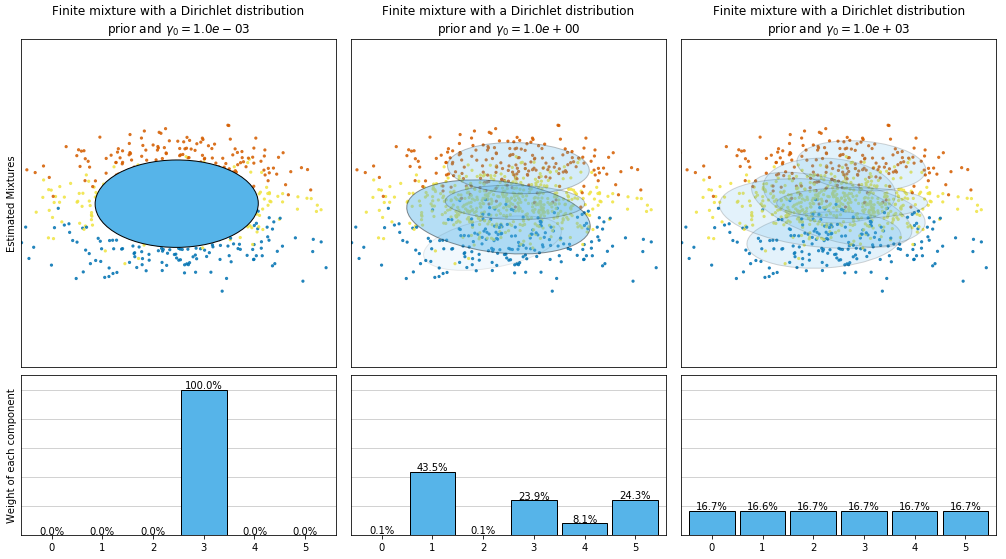

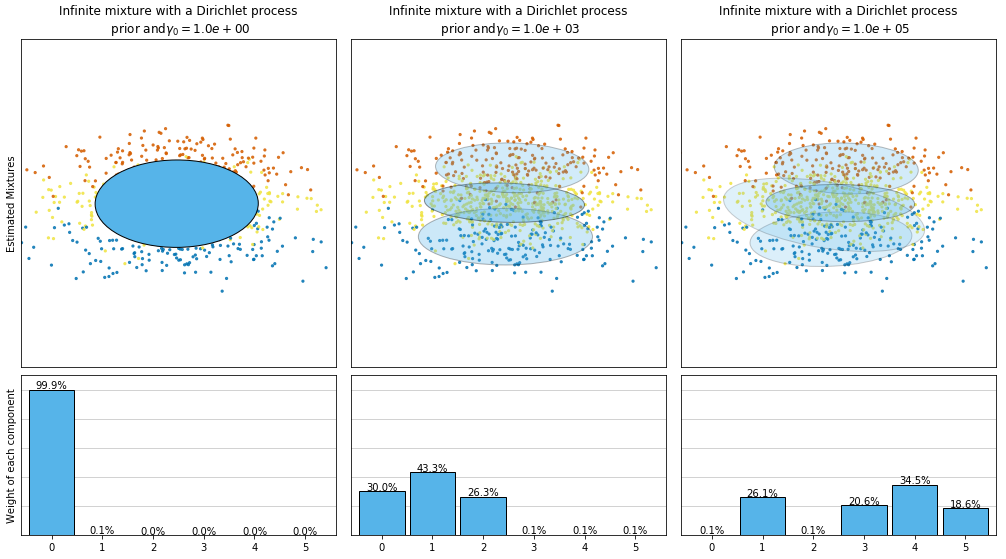

In [16]:
estimators = [
    ("Finite mixture with a Dirichlet distribution\nprior and "
     r"$\gamma_0=$", BayesianGaussianMixture(
        weight_concentration_prior_type="dirichlet_distribution",
        n_components=2 * n_components, reg_covar=0, init_params='random',
        max_iter=1500, mean_precision_prior=.8,), [0.001, 1, 1000]),
    ("Infinite mixture with a Dirichlet process\n prior and" r"$\gamma_0=$",
     BayesianGaussianMixture(
        weight_concentration_prior_type="dirichlet_process",
        n_components=2 * n_components, reg_covar=0, init_params='random',
        max_iter=1500, mean_precision_prior=.8), [1, 1000, 100000])]

# Plot results in two different figures
for (title, estimator, concentrations_prior) in estimators:
    plt.figure(figsize=(4.7 * 3, 8))
    plt.subplots_adjust(bottom=.04, top=0.90, hspace=.05, wspace=.05,
                        left=.03, right=.99)

    gs = gridspec.GridSpec(3, len(concentrations_prior))
    for k, concentration in enumerate(concentrations_prior):
        estimator.weight_concentration_prior = concentration
        estimator.fit(X)
        plot_results(plt.subplot(gs[0:2, k]), plt.subplot(gs[2, k]), estimator,
                     X, y, r"%s$%.1e$" % (title, concentration),
                     plot_title=k == 0, n_components=n_components)

plt.show()

##### Exercises
1. Load the iris dataset. Fit it with a BayesianGaussianMixture using the two different types of prior.
2. Play with the prior hyper parameters to try to infer the total number of underlying labels.

### Factor Analysis
A similar mixture formulation called [Factor Analysis](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FactorAnalysis.html#sklearn.decomposition.FactorAnalysis) allows for dimensionality reduction. The observations are assumed to be caused by a linear transformation of lower dimensional latent factors and added Gaussian noise. Without loss of generality the factors are distributed according to a Gaussian with zero mean and unit covariance. The noise is also zero mean and has an arbitrary diagonal covariance matrix.

FactorAnalysis performs a maximum likelihood estimate of the so-called loading matrix, the transformation of the latent variables to the observed ones, using expectation-maximization (EM).

$$
x - \mu = LF + \varepsilon
$$

where $F$ are the latent normal variables (components), and $L$ is the loading matrix, which are the unknown weights of each factor.

In [17]:
from sklearn.datasets import fetch_olivetti_faces
dataset = fetch_olivetti_faces(shuffle=True)
faces = dataset.data
dataset.keys()

dict_keys(['data', 'images', 'target', 'DESCR'])

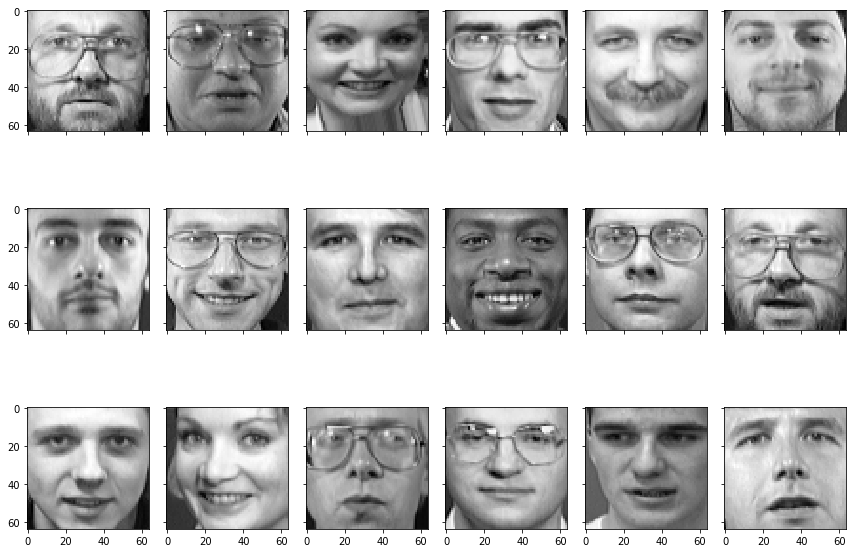

In [18]:
fig, axs = plt.subplots(3, 6, figsize=(12, 9), sharex=True, sharey=True)
for i in range(18):
    ax = axs[i // 6, i % 6]
    ax.imshow(dataset.images[i], cmap='gray')
fig.tight_layout()

In [19]:
print(faces.shape)

(400, 4096)


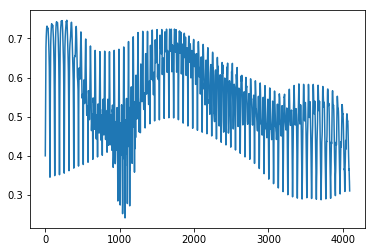

In [20]:
plt.plot(np.mean(faces, axis=0))

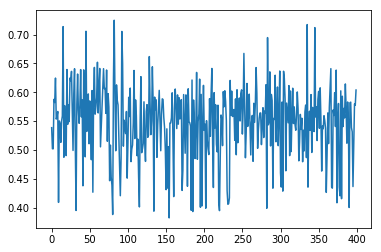

In [21]:
plt.plot(np.mean(faces, axis=1))

Dataset consists of 400 faces


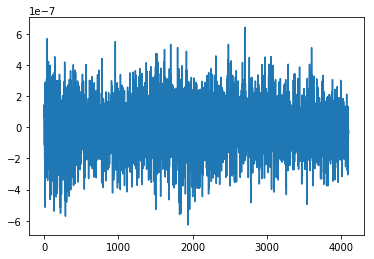

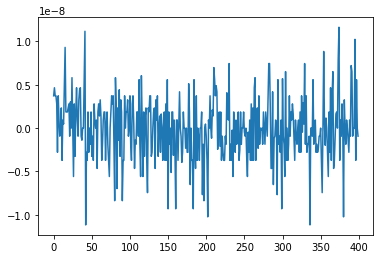

In [22]:
from sklearn.decomposition import FactorAnalysis

image_shape = (64, 64)

n_samples, n_features = faces.shape

# global centering
faces_centered = faces - faces.mean(axis=0)

# local centering
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

print("Dataset consists of %d faces" % n_samples)
plt.figure()
plt.plot(np.mean(faces_centered, axis=0))
plt.figure()
plt.plot(np.mean(faces_centered, axis=1))

In [23]:
def plot_gallery(title, images, n_col=5, n_row=2, cmap=plt.cm.gray):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

In [24]:
n_row, n_col = 2, 5
n_components = n_row * n_col

estimator = FactorAnalysis(n_components=n_components, max_iter=100)
estimator.fit(faces_centered)
estimator

FactorAnalysis(copy=True, iterated_power=3, max_iter=100, n_components=10,
        noise_variance_init=None, random_state=0, svd_method='randomized',
        tol=0.01)

In [25]:
estimator.components_.shape

(10, 4096)

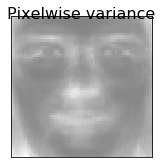

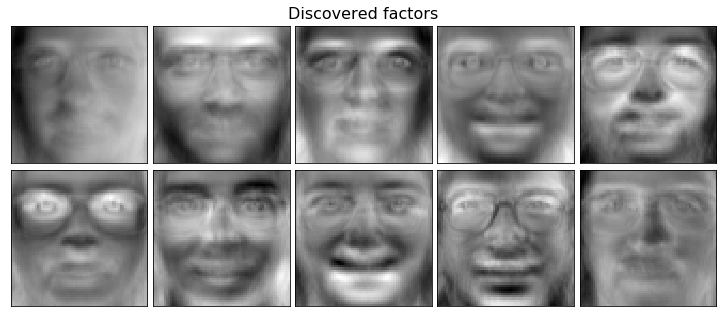

In [26]:
# Plot an image representing the pixelwise variance provided by the
# estimator e.g its noise_variance_ attribute.
plot_gallery("Pixelwise variance",
             estimator.noise_variance_.reshape(1, -1), n_col=1,
             n_row=1)
plot_gallery('Discovered factors',
             estimator.components_[:n_components],
             n_col=n_col, n_row=n_row)

We can also transform the images into the latent components

In [27]:
transformed_faces = estimator.transform(faces_centered)
transformed_faces.shape

(400, 10)

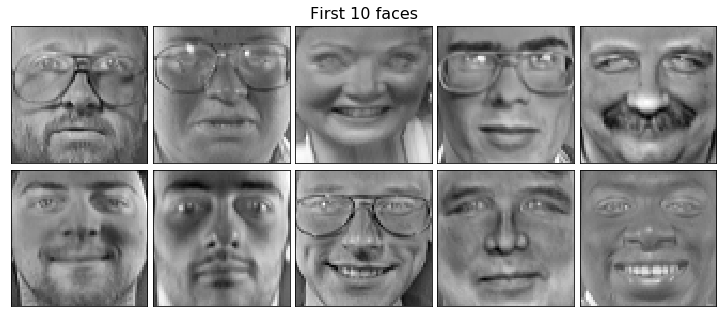

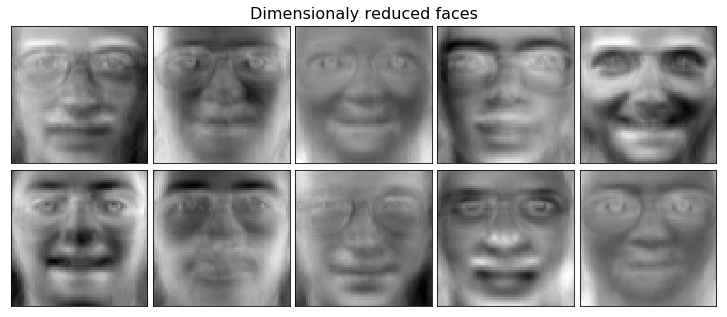

In [28]:
plot_gallery('First 10 faces',
             faces_centered[:n_components],
             n_col=n_col, n_row=n_row)
plot_gallery('Dimensionaly reduced faces',
             np.dot(transformed_faces, estimator.components_)[:n_components],
             n_col=n_col, n_row=n_row)

##### Exercise
1. Use the `FactorAnalysis` to reduce the dimensionality of the digits dataset.
2. Select the best number of components by miximizing the [`ShrunkCovariance`](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.ShrunkCovariance.html#sklearn.covariance.ShrunkCovariance) score of the transformed dataset. (Hint: `ShrunkCovariance` must be `fit` to the transformed data, and then you get the score by calling the `score` method on the same data). As a further complication, you can also estimate the best shrinkage for through cross validation (see [here](https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_fa_model_selection.html#sphx-glr-auto-examples-decomposition-plot-pca-vs-fa-model-selection-py) for hints on how to implement that)